Few Snippets in this notebook are been reffered from the given reference notebooks.

Importing required libraries


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from scipy.stats import randint as uniform
from pandas import read_hdf
from scipy.sparse.linalg import svds
from sklearn.metrics import confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install tables

Note: you may need to restart the kernel to use updated packages.


Reading the data formed from final features

In [4]:
train = read_hdf('/home/naveenkateghar/storage_sample_stage4.h5', 'train_df',mode='r')
test = read_hdf('/home/naveenkateghar/storage_sample_stage4.h5', 'test_df',mode='r')

Creating Graph formed from training data which are positively labelled

In [5]:
train_graph=nx.read_edgelist('/home/naveenkateghar/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


Preferrential Attachment Feature 

In [6]:
def preferrential_attachment_for_followees(source_node,destination_node):
  try:
        if len(set(train_graph.successors(source_node))) == 0  | len(set(train_graph.successors(destination_node))) == 0:
            return 0
        sim = (len(set(train_graph.successors(source_node))))* (len(set(train_graph.successors(destination_node))))
  except:
        return 0
  return sim

In [7]:
def preferrential_attachment_for_followers(source_node,destination_node):
  try:
        if len(set(train_graph.predecessors(source_node))) == 0  | len(set(train_graph.predecessors(destination_node))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(source_node))))* (len(set(train_graph.predecessors(destination_node))))
  except:
        return 0
  return sim

In [8]:
train['preferrential_attachment_for_followees'] = train.apply(lambda row:
                                            preferrential_attachment_for_followees(row['source_node'],row['destination_node']),axis=1)

In [9]:
train['preferrential_attachment_for_followers'] = train.apply(lambda row:
                                            preferrential_attachment_for_followers(row['source_node'],row['destination_node']),axis=1)

In [10]:
test['preferrential_attachment_for_followees'] = test.apply(lambda row:
                                            preferrential_attachment_for_followees(row['source_node'],row['destination_node']),axis=1)

In [11]:
test['preferrential_attachment_for_followers'] = test.apply(lambda row:
                                            preferrential_attachment_for_followers(row['source_node'],row['destination_node']),axis=1)

In [12]:
train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferrential_attachment_for_followees,preferrential_attachment_for_followers
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,120,66
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,8662,1598
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,902,980
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,35,22
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,33,5


In [13]:
test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferrential_attachment_for_followees,preferrential_attachment_for_followers
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,...,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,54,84
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,...,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,19,34
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,...,2.740535e-13,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,144,150
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,...,4.020707e-12,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,340,407
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,...,1.154623e-12,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,405,324


svd_dot Feature

In [14]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [15]:
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [16]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [17]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [18]:
train['svd_dot_s']=train.apply(lambda row:
                               np.dot(np.array(svd(row['source_node'],U)),np.array(svd(row['destination_node'],U))),axis=1)

In [19]:
train['svd_dot_d']=train.apply(lambda row:
                               np.dot(np.array(svd(row['source_node'],V.T)),np.array(svd(row['destination_node'],V.T))),axis=1)

In [20]:
test['svd_dot_s']=test.apply(lambda row:
                               np.dot(np.array(svd(row['source_node'],U)),np.array(svd(row['destination_node'],U))),axis=1)

In [21]:
test['svd_dot_d']=test.apply(lambda row:
                               np.dot(np.array(svd(row['source_node'],V.T)),np.array(svd(row['destination_node'],V.T))),axis=1)

In [22]:
train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferrential_attachment_for_followees,preferrential_attachment_for_followers,svd_dot_s,svd_dot_d
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,120,66,1.114951e-11,2.238777e-12
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,8662,1598,3.192812e-03,9.068719e-04
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,902,980,1.305279e-35,1.730842e-36
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,35,22,4.710691e-20,3.159735e-18
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,33,5,7.775088e-14,3.708786e-16


In [23]:
test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferrential_attachment_for_followees,preferrential_attachment_for_followers,svd_dot_s,svd_dot_d
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,...,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,54,84,8.425175e-20,2.074802e-17
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,...,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,19,34,1.352149e-17,1.188365e-17
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,...,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,144,150,3.671977e-13,3.904906e-12
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,...,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,340,407,1.634039e-10,9.819746e-11
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,...,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,405,324,1.246695e-11,1.300884e-11


In [24]:
x_train=train.drop(['source_node', 'destination_node','indicator_link'],axis=1)
y_train=train.indicator_link
x_test=test.drop(['source_node', 'destination_node','indicator_link'],axis=1)
y_test=test.indicator_link

In [25]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(100002, 55)
(100002,)
(50002, 55)
(50002,)


In [26]:
x_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferrential_attachment_for_followees',
       'preferrential_attachment_for_followers', 'svd_dot_s', 'svd_dot_d'],
      dtype='object')

Hyperparameter tuning of XGBoost

In [27]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [28]:
param_grid={"n_estimators":sp_randint(105,125),
            "max_depth": [5,6,7,8,9],
            "learning_rate":[0.01,0.1,0.2,0.002,0.300000012],
            "colsample_bytree":[0.5,0.6,0.8,0.9,1.0]
           }
clf=XGBClassifier(objective='binary:logistic',eval_metric='logloss')
rscv=RandomizedSearchCV(clf,param_grid,return_train_score=True,n_iter=10,scoring='f1',cv=3)
rscv.fit(x_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [29]:
pd.DataFrame(rscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,9.264249,0.029971,0.038540,0.001043,0.6,0.01,7,106,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",0.967889,0.968038,0.966837,0.967588,0.000535,6,0.968096,0.968831,0.969466,0.968798,0.000560
1,12.744692,0.057470,0.036093,0.000818,1.0,0.2,6,106,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.981453,0.979624,0.979603,0.980227,0.000867,2,0.990871,0.990781,0.990875,0.990843,0.000043
2,11.376731,0.105282,0.048136,0.001474,0.6,0.1,9,111,"{'colsample_bytree': 0.6, 'learning_rate': 0.1...",0.979982,0.978660,0.978473,0.979038,0.000672,4,0.990433,0.991862,0.991344,0.991213,0.000591
3,9.119087,0.038509,0.044990,0.000320,0.5,0.002,7,121,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.964339,0.965303,0.963926,0.964523,0.000577,9,0.964818,0.965219,0.966022,0.965353,0.000500
4,10.151661,0.090156,0.050053,0.000984,0.5,0.002,8,120,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.967593,0.967732,0.966618,0.967314,0.000496,7,0.968589,0.968978,0.969370,0.968979,0.000319
5,15.926777,0.177928,0.049290,0.001024,0.9,0.1,9,114,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",0.980468,0.978288,0.978632,0.979129,0.000957,3,0.991271,0.991548,0.992288,0.991702,0.000429
6,16.248667,0.117874,0.052060,0.000582,0.8,0.01,9,122,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.972784,0.973290,0.972591,0.972888,0.000295,5,0.974969,0.977009,0.976235,0.976071,0.000841
7,17.255714,0.263696,0.048296,0.000367,1.0,0.002,9,110,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.964304,0.967018,0.966112,0.965811,0.001128,8,0.968043,0.968405,0.969593,0.968680,0.000662
8,8.203457,0.022192,0.038635,0.000665,0.5,0.01,6,122,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.964934,0.964482,0.963011,0.964142,0.000821,10,0.964379,0.965010,0.965258,0.964882,0.000370
9,14.738840,0.115325,0.045933,0.000798,0.9,0.2,7,120,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.981830,0.980378,0.980430,0.980879,0.000673,1,0.997058,0.996741,0.996741,0.996847,0.000149


In [30]:
rscv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=120, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [31]:
rscv.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.2,
 'max_depth': 7,
 'n_estimators': 120}

Modelling

In [32]:
best_clf=XGBClassifier(colsample_bytree=rscv.best_params_['colsample_bytree'],
 learning_rate=  rscv.best_params_['learning_rate'],
 max_depth= rscv.best_params_['max_depth'],
 n_estimators=rscv.best_params_['n_estimators'])

In [33]:
best_clf.fit(x_train,y_train,eval_metric='logloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=120, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<h3><b>Results</b></h3>

In [34]:
y_pred_train=best_clf.predict(x_train)
print("Train F1 Score=",f1_score(y_train,y_pred_train))

Train F1 Score= 0.9949903815325425


In [35]:
y_pred_test=best_clf.predict(x_test)
print("Test F1 Score=",f1_score(y_test,y_pred_test))

Test F1 Score= 0.9258629484781499


In [36]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


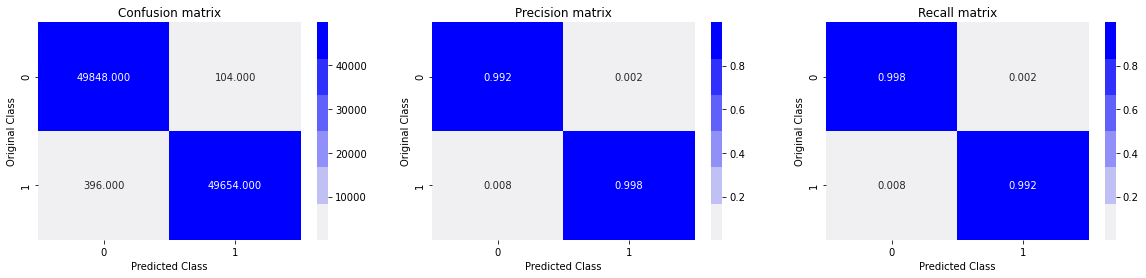

Test confusion_matrix


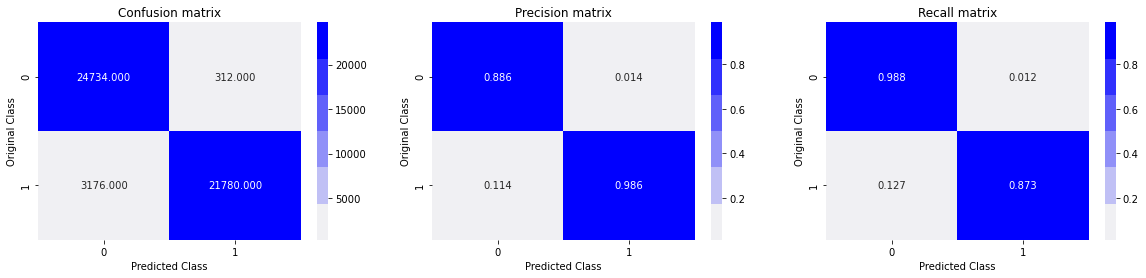

In [37]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_pred_train)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_pred_test)

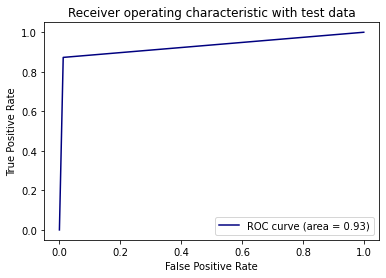

In [38]:
fpr,tpr,ths = roc_curve(y_test,y_pred_test)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

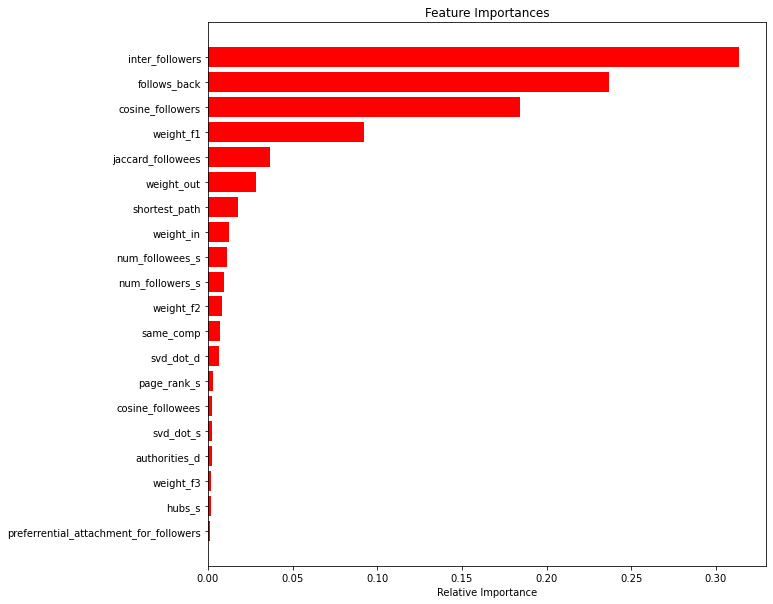

In [39]:
features = x_train.columns
importances = best_clf.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**<h3>Steps followed in this case study :</h3>**

1)Initially with the given Edge information,we got estimates for what percentage of people have how many number of followers and what percentage of people follow how many number of people.

2)Then, we created data points with negative labels, so as to pose this problem as a binary classification problem.

3)For creating negative datapoints we can't directly take all the missing edges as negative label because then the dataset becomes very huge and also it gets imbalanced.Hence, we try to sample the missing edges of size equal to that of positive labels.we only include those edges as negative label in our dataset for which shortest path between those vertices of users is greater than 2.

4)Then,we did a 80-20 split of our data to create train and test sets.

5)Next, we performed Featurization i.e, we have included Graph based similarity features.

6)We included features like Jaccard Distance,CosineDistance,PageRank,Shortest path,same_community,AdarIndex,follows_back,Katz Centrality,Hits Score,num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees,hubs,authorities_,svd features.

7)In this Notebook we have included 2 more types of features which are preferrential_attachment and svd_dot.

8)Then, we have tuned a few parameters for Xgboost using RandomizedSearchCV.

9)We have selected f1_score as the error metric because we have to get best precision and recall scores because the model should not miss out any recommendation for a user(High Recall) and the model should not wrongly recommend friends(High Precision).

10)To visulaize the results we plotted confusion matrix for both test and train sets and also the ROC curve.Finally we also plotted a horizontal bar graph as in to know which features were important to predict recommendation for users.